# Compare NLP Techniques: Build A Basic RNN

### Read In Cleaned Text

In [2]:
# Load the cleaned training and test sets
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import pandas as pd

X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

### Prep Data

In [3]:
# Train the tokenizer and use that tokenizer to convert the sentences to sequences of numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['clean_text'])
X_train_seq = tokenizer.texts_to_sequences(X_train['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_text'])

In [5]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

### Build And Evaluate RNN

In [6]:
# Import the tools needed and use our previously defined functions to calculate precision and recall
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [7]:
# Construct our basic RNN model framework
model = Sequential([
    Embedding(len(tokenizer.index_word)+1, 32),
    LSTM(32, dropout=0.5, recurrent_dropout=0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          264768    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 274,177
Trainable params: 274,177
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [10]:
# Fit the RNN
history = model.fit(X_train_seq_padded, y_train['label'], 
                    batch_size=32, epochs=10, verbose=2,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 - 3s - loss: 0.1212 - accuracy: 0.9598 - precision_m: 0.8554 - recall_m: 0.7229 - val_loss: 0.0632 - val_accuracy: 0.9839 - val_precision_m: 0.9857 - val_recall_m: 0.9032 - 3s/epoch - 19ms/step
Epoch 2/10
140/140 - 2s - loss: 0.0273 - accuracy: 0.9928 - precision_m: 0.9828 - recall_m: 0.9529 - val_loss: 0.0668 - val_accuracy: 0.9865 - val_precision_m: 1.0000 - val_recall_m: 0.9175 - 2s/epoch - 17ms/step
Epoch 3/10
140/140 - 2s - loss: 0.0102 - accuracy: 0.9973 - precision_m: 0.9879 - recall_m: 0.9789 - val_loss: 0.0725 - val_accuracy: 0.9848 - val_precision_m: 1.0000 - val_recall_m: 0.9023 - 2s/epoch - 18ms/step
Epoch 4/10
140/140 - 2s - loss: 0.0046 - accuracy: 0.9993 - precision_m: 1.0000 - recall_m: 0.9936 - val_loss: 0.0667 - val_accuracy: 0.9865 - val_precision_m: 0.9905 - val_recall_m: 0.9232 - 2s/epoch - 17ms/step
Epoch 5/10
140/140 - 2s - loss: 0.0031 - accuracy: 0.9989 - precision_m: 0.9839 - recall_m: 0.9805 - val_loss: 0.0535 - val_accuracy: 0.9874 - val_p

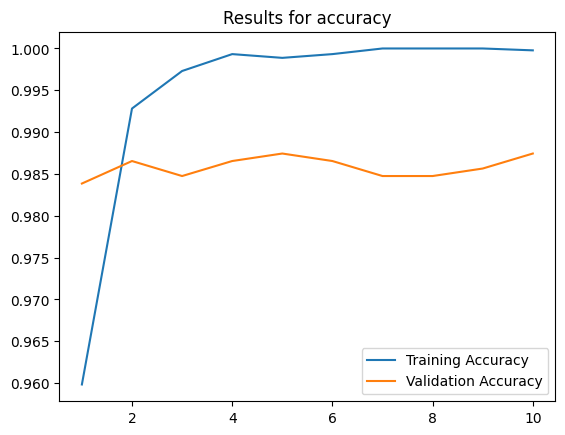

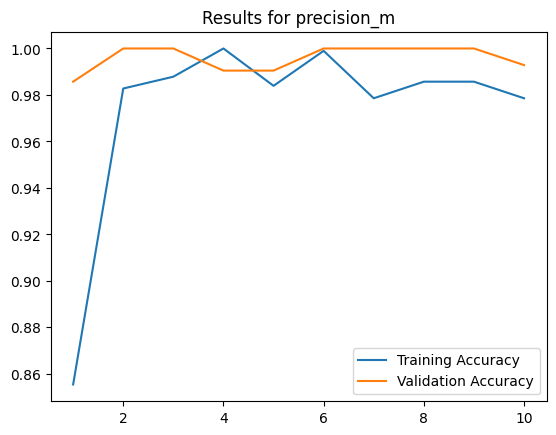

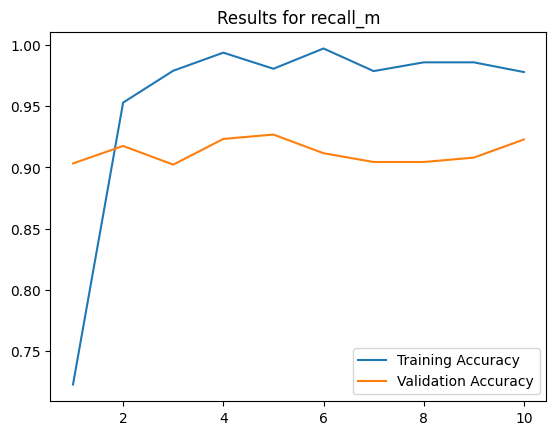

In [11]:
# Plot basic evaluation metrics across epochs
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()